# Speech-to-Intent Model Training and Conversion to Tensorflow Lite for Microcontrollers

Follow this notebook to understand the workflow and the internal workings of the Speech-to-Intent application. The training script includes more options and other model architectures.

First we do the necessary imports. Before running this notebook make sure you installed the necessary packages with 
```pip install -r requiremnts.txt```
It is preferred to either use virtualenv or conda.

Change the path to dataset .csv files and parameters of audio processing in the next cell if needed.

In [12]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm

import io, base64
import os, sys
from datetime import datetime

import IPython
import pickle

from sklearn.utils import shuffle
import string

from tensorflow.keras.utils import Sequence

import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, AddBackgroundNoise, PitchShift, Shift, ClippingDistortion, Gain, LoudnessNormalization, TimeStretch 
from tensorflow.python.ops import gen_audio_ops as contrib_audio

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Flatten
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

from keras import backend as K 

import random 
import glob

from tensorflow.keras.models import load_model

import scipy.io.wavfile as wav

DEBUG = False

train_dataset_path = '../data/csv/train_data.csv'
valid_dataset_path = '../data/csv/valid_data.csv'
test_dataset_path = '../data/csv/test_data.csv'

SAMPLING_RATE = 16000
MIN_FREQ = 100
MAX_FREQ = SAMPLING_RATE//2
WIN_SIZE_MS = 0.02
WIN_INCREASE_MS = 0.02
NUM_CEPSTRAL = 10

Let's open the test dataset and have a look at it's content. 

In [13]:
test_data = pd.read_csv(test_dataset_path)
test_data.head()

,path,transcription,action,object,location
0,D:\Eshang Documents\PGP Intern\Fluent\Speech-t...,one,Add 1,Glass,TPD45
1,D:\Eshang Documents\PGP Intern\Fluent\Speech-t...,one,Add 1,Glass,TPD45
2,D:\Eshang Documents\PGP Intern\Fluent\Speech-t...,one,Add 1,Glass,TPD45
3,D:\Eshang Documents\PGP Intern\Fluent\Speech-t...,one,Add 1,Glass,TPD45
4,D:\Eshang Documents\PGP Intern\Fluent\Speech-t...,one,Add 1,Glass,TPD45


For a quick dataset sanity check - especially useful if you are crearing the dataset yourself, let's listen to the first entry and make sure it mathces the transcription.

In [14]:
prefix = ["..", "data"]
wav_file = os.path.join(*prefix, test_data['path'][0])
print(wav_file)
IPython.display.Audio(wav_file)

D:\Eshang Documents\PGP Intern\Fluent\Speech-to-Intent-Micro\Train\Eshang_1\1.wav.438dcsbr.ingestion-5bfb7d65cc-ktlgk.s20.wav


In order to match MFCC processing parameters on device, we use audio_spectrogram and mfcc functions from Tensorflow gen_audio_ops. In generate_features function we create a spectrogram, convert it to mel frequency and (optionally) visualize it with matplotlib. In the next cell we run this process for the above .wav file.

{'type': 'spectrogram', 'shape': {'width': 10, 'height': 50}}


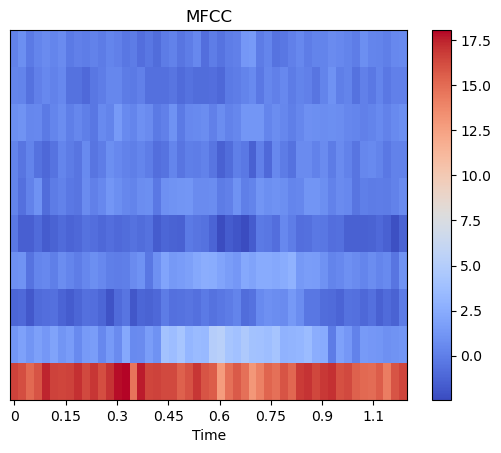

In [15]:
audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')

if DEBUG:
    print(wav_file)

def generate_features(draw_graphs, raw_data, sampling_freq,
                      frame_length, frame_stride, num_filters, 
                      num_cepstral, low_frequency, high_frequency):
    graphs = []
    
    raw_data = np.expand_dims(raw_data, axis = -1)
    window_size = int(sampling_freq * frame_length)
    stride = int(sampling_freq * frame_stride)
    
    spectrogram = contrib_audio.audio_spectrogram(
        raw_data,
        window_size=window_size,
        stride=stride,
        magnitude_squared=True)
    
    mfcc = contrib_audio.mfcc(
        spectrogram,
        sampling_freq,
        dct_coefficient_count=num_cepstral,
        upper_frequency_limit=high_frequency, 
        lower_frequency_limit=low_frequency)
    
    mfcc = np.squeeze(mfcc)

    if draw_graphs:
        mfcc_graph = np.swapaxes(mfcc, 0, 1)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mfcc_graph, x_axis='time', ax=ax)
        fig.colorbar(img, ax=ax)
        ax.set(title='MFCC')
        buf = io.BytesIO()

        plt.savefig(buf, format='svg', bbox_inches='tight', pad_inches=0)

        buf.seek(0)
        image = (base64.b64encode(buf.getvalue()).decode('ascii'))

        buf.close()

        graphs.append({
            'name': 'Cepstral Coefficients',
            'image': image,
            'imageMimeType': 'image/svg+xml',
            'type': 'image'
        })

    return {
        'features': mfcc,
        'graphs': graphs,
        'output_config': {
            'type': 'spectrogram',
            'shape': {
                'width': mfcc.shape[1],
                'height': mfcc.shape[0]
            }
        }
    }

processed = generate_features(True, audio, SAMPLING_RATE, 
                              WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                              NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

if DEBUG:
    print(processed['features'])
    
print(processed['output_config'])

In the next cell we process the .csv file data into ground truth labels for the model. Slots include both words for objects and locations, while intents include only words for actions. During preprocessing we also create a common vocabulary, including all the words in transcriptions, slots and intents, but it is not used in training. 
In order to ensure the consistency between runs, as long as you use the same dataset, it only necessary to create and save vectorized training/validation data and reverse dictionaries (for decoding) once. 

In [16]:
class DatasetFactory:
    
    def __init__(self):
        self.actions = set()
        self.objects = set()
        self.locations = set()
        self.vocab = set()
    
    def get_query_slots(self, sentence):

        slots = [sentence[0], sentence[1]]
        return slots      
    
    def get_properties(self, data):

        data["action"] = data['action'].str.lower()
        data["object"] = data['object'].str.lower()
        data["location"] = data['location'].str.lower()

        actions = set(data.action.unique())
        objects = set(data.object.unique())
        locations = set(data.location.unique())

        return actions, objects, locations        

    def get_vocab(self, actions, objects, locations, data):

        vocab = objects | locations

        if DEBUG:
            print(vocab)

        data["transcription"] = data['transcription'].str.replace('[^\w\s]','')
        data["transcription"] = data['transcription'].str.lower()

        for item in data.transcription:
            for word in item.split(" "):
                vocab.add(word)

        vocab = [s.strip() for s in vocab]
        
        return set(vocab)   

    def add_corpora(self, data):
        
        actions, objects, locations = self.get_properties(data)
        vocab = self.get_vocab(actions, objects, locations, data)

        self.actions = set(self.actions | actions)
        self.objects = set(self.objects | objects)
        self.locations = set(self.locations | locations)        
        self.vocab = set(self.vocab | vocab)  
        self.query_slots = set(self.objects | self.locations)

    def process_data(self, data):
        
        self.actions = list(self.actions)
        self.objects = list(self.objects)
        self.locations = list(self.locations)       
        self.vocab = list(self.vocab)
        self.query_slots = list(self.query_slots)
        
        word_ids, slot_ids, intent_ids = {' ': 0}, {}, {self.actions[i]: i for i in range(0, len(self.actions))}

        slots = []
        for sentence in zip(data.object, data.location):
            slots.append(self.get_query_slots(sentence))
        
        i = 0
        for slot in self.query_slots:
            if slot == 'none':
                continue
            slot_ids[slot] = i
            i += 1
            
        slot_ids['none'] = i

        #convert vocab to dictionary
        start = 1
        for i in range(len(self.vocab)):
            word_ids[self.vocab[i]] = start + i
        word_ids['unknown'] =  i + 1  

        #create reverse dicts
        ids2words = dict((v, k) for k, v in word_ids.items())
        ids2slots = dict((v, k) for k, v in slot_ids.items())
        ids2intents = dict((v, k) for k, v in intent_ids.items())

        n_vocab = len(ids2words)

        n_classes = len(ids2intents)
        n_slots = len(ids2slots)

        vectorized_slots = list(map(lambda slots: np.array(list(map(lambda slot: slot_ids[slot], slots))), slots))
        vectorized_intents = list(map(lambda l: np.array([intent_ids[l]]), data.action))

        filepaths = data['path'].to_numpy()

        return ids2intents, ids2slots, vectorized_slots, vectorized_intents, filepaths        
    
def save_obj(obj, name):
    with open('../data/pkl/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('../data/pkl/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

generate_data = True #change that to True the first time you are running the code

train_data = pd.read_csv(train_dataset_path)
valid_data = pd.read_csv(valid_dataset_path)
test_data = pd.read_csv(test_dataset_path)

if generate_data:
    
    dataset_processor = DatasetFactory()
    
    train_data = pd.read_csv(train_dataset_path)
    valid_data = pd.read_csv(valid_dataset_path)
    test_data = pd.read_csv(test_dataset_path)
    
    dataset_processor.add_corpora(train_data)
    dataset_processor.add_corpora(valid_data)
    dataset_processor.add_corpora(test_data)
    
    ids2intents, ids2slots, vectorized_slots_train, vectorized_intents_train, filepaths_train = dataset_processor.process_data(train_data)
    _ids2intents, _ids2slots, vectorized_slots_valid, vectorized_intents_valid, filepaths_valid = dataset_processor.process_data(valid_data)
    __ids2intents, __ids2slots, vectorized_slots_test, vectorized_intents_test, filepaths_test = dataset_processor.process_data(test_data)

    assert ids2intents == _ids2intents == __ids2intents
    assert ids2slots == _ids2slots == __ids2slots
    
    save_obj(ids2intents, 'ids2intents')
    save_obj(ids2slots, 'ids2slots')
    
    save_obj(vectorized_slots_train, 'vectorized_slots_train')
    save_obj(vectorized_intents_train, 'vectorized_intents_train')
    
    save_obj(vectorized_slots_valid, 'vectorized_slots_valid')
    save_obj(vectorized_intents_valid, 'vectorized_intents_valid')
    
    save_obj(vectorized_slots_test, 'vectorized_slots_test')
    save_obj(vectorized_intents_test, 'vectorized_intents_test') 
    
else:

    filepaths_train = train_data['path'].to_numpy()
    filepaths_valid = valid_data['path'].to_numpy()
    filepaths_test = test_data['path'].to_numpy()
    
    ids2intents = load_obj('ids2intents')
    ids2slots = load_obj('ids2slots')
    
    vectorized_slots_train = load_obj('vectorized_slots_train')
    vectorized_intents_train = load_obj('vectorized_intents_train')
    
    vectorized_slots_valid = load_obj('vectorized_slots_valid')
    vectorized_intents_valid = load_obj('vectorized_intents_valid')
    
    vectorized_slots_test = load_obj('vectorized_slots_test')
    vectorized_intents_test = load_obj('vectorized_intents_test')
    
if DEBUG:
    print(vectorized_slots_test)
    print(vectorized_intents_test)
    print(ids2intents) 
    print(ids2slots) 

print(str(ids2intents.values()).replace("'", "\"")) 
print(str(ids2slots.values()).replace("'", "\"")) 

n_classes = len(ids2intents)
n_slots = len(ids2slots)    

C:\Users\eshan\AppData\Local\Temp\ipykernel_1380\2814521526.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  data["transcription"] = data['transcription'].str.replace('[^\w\s]','')


dict_values(["add 3", "add 2", "add 1"])
dict_values(["glass", "tpd45", "none"])


Below data generator class is create and instantiated. In the actual training we limiut the length of samples to 3 seconds by zero padding shorter samples and trimming the longer. Additionally since training data only contains noise-free samples we apply aggressive audio augmentation pipeline. While applying data agumentation is slower than augmenting MFCC features directly, it is much easier to examine augmented augio samples than it is inspect MFCC visualization.

In [17]:
def create_aug_pipeline():
    
    aug_pipeline = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.1),
    ClippingDistortion(p=0.3),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.2),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.1),
    Gain(p=0.2),
    TimeStretch(p=0.05)
    ])
    
    return aug_pipeline

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, entries, num_list, batch_size, shuffle=True, to_fit=True, augment = True, vis = False):

        self.entries = entries
        self.batch_size = batch_size
        
        self.n_intents, self.n_slots = num_list
        
        self.len = 2
        self.aug_pipeline = None
        if augment:
            self.aug_pipeline = create_aug_pipeline()
        self.vis = vis
        self.shuffle = shuffle
        self.to_fit = to_fit
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.entries[0]) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        X_batch = [self.entries[0][k] for k in indexes]
        
        Y_intent = [self.entries[1][k] for k in indexes]
        Y_slot = [self.entries[2][k] for k in indexes]
        
        # Generate data
        X = self._generate_X(X_batch)

        if self.to_fit:
            y = self._generate_y(Y_intent, Y_slot)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.entries[0]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, batch_items):

        X = np.zeros(shape = (self.batch_size, 150, NUM_CEPSTRAL, 1))
         
        for i, batch_item in enumerate(batch_items):
            wav_file = os.path.join(*prefix, batch_item)
            audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
            audio = librosa.util.fix_length(audio, 16000*3)
            
            if self.aug_pipeline:
                audio = self.aug_pipeline(audio, sample_rate)
                
                if DEBUG:
                    new_filename = os.path.join('samples', os.path.basename(batch_item.split('.')[0]+'aug.wav'))
                    print("Augmented: ", new_filename)
                    print("--------------")
                    sf.write(new_filename, audio, sample_rate,  subtype='PCM_16')
                
            output = generate_features(self.vis, audio, SAMPLING_RATE, 
                                          WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                                          NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

            features = output['features']
            X[i, ] = np.expand_dims(features, axis = -1)
        return X
    
    def _generate_y(self, intents, slots):
        intent_y = np.empty((self.batch_size, self.n_intents), dtype=int)
        slot_y = np.empty((self.batch_size, self.len, self.n_slots), dtype=int)      

        # Generate data
        for i, batch_item in enumerate(intents):
            intent = intents[i]
            slot = slots[i]
            intent_y[i,] = np.eye(self.n_intents)[intent]
            slot_y[i,] = np.eye(self.n_slots)[slot][np.newaxis, :]
        
        return [intent_y, slot_y]

batch_size = 32   
    
training_generator = DataGenerator([filepaths_train, vectorized_intents_train, vectorized_slots_train], 
                                   [n_classes,n_slots], batch_size = batch_size, 
                                   shuffle=True, to_fit=True, augment = True)

data = training_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(training_generator.__len__())

validation_generator = DataGenerator([filepaths_valid, vectorized_intents_valid, vectorized_slots_valid], 
                                     [n_classes,n_slots], batch_size = batch_size, 
                                     shuffle=False, to_fit=True, augment = False)


data = validation_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(validation_generator.__len__())

test_generator = DataGenerator([filepaths_test, vectorized_intents_test, vectorized_slots_test], 
                                     [n_classes, n_slots], batch_size = batch_size, vis = False,
                                     shuffle=False, to_fit=True, augment = False)

data = test_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(test_generator.__len__())

C:\Users\eshan\AppData\Local\Temp\ipykernel_1380\1651305707.py:76: FutureWarning: Pass size=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.util.fix_length(audio, 16000*3)


(32, 150, 10, 1)
(32, 3)
(32, 2, 3)
1
(32, 150, 10, 1)
(32, 3)
(32, 2, 3)
0
(32, 150, 10, 1)
(32, 3)
(32, 2, 3)
0


The model architecture used in this Jupyter notebook is very basic and consists of 2D Convolutional layers followed by Batch Normalization and (ecxept for first and last layer) Max Pooling 2D layers. Then Global Max Pooling is applied and resulting feature maps are fed into Dense layer and then to slot and intent outputs. 
There are more advanced feature extractor architectures included in training script, e.g. 
- MobileNetv1-like DepthWise convolution layers
- MobileNetv3-like residual blocks
Additionally, in future it is planned to add Attention layer and RNN layers after feature extractor.

In [26]:
K.clear_session()

main_input = Input(shape=(150, NUM_CEPSTRAL, 1), name='main_input')

x = Conv2D(16, 3, padding='same', activation='relu', use_bias = False)(main_input)
x = BatchNormalization()(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(32, 3, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(128, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling2D()(x)

x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

slot_dense = Dense(n_slots*2)(x)
slot_reshape = Reshape(target_shape = (2, n_slots))(slot_dense)
slot_output = Softmax(name='slot_output')(slot_reshape)

intent_output = Dense(n_classes, activation='softmax', name='intent_output', use_bias = False)(x)

model = Model(inputs=main_input, outputs=[intent_output, slot_output])

optim = Adam(learning_rate=1e-3, decay=1e-6)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 150, 10, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 150, 10, 16)  144         ['main_input[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 10, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

We create a folder for the experiment and start the training.

In [27]:
output_path = os.path.join("..", "checkpoints", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.mkdir(output_path)
print("Project folder: {}".format(output_path))

model_name = os.path.join(output_path, "slu_model.h5")
                           
my_callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True, verbose = 1),
    ModelCheckpoint(filepath=model_name, save_weight_only=True, verbose = 1),
    TensorBoard(log_dir='./logs'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-6, verbose = 1)]
try:
    model.fit(training_generator, validation_data = test_generator,
              callbacks = my_callbacks, epochs=11, 
              workers = 4, max_queue_size = 10,
              use_multiprocessing = False)
except KeyboardInterrupt:
    raise

Project folder: ..\checkpoints\2023-06-24_11-40-00


C:\Users\eshan\AppData\Local\Temp\ipykernel_1380\1651305707.py:76: FutureWarning: Pass size=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.util.fix_length(audio, 16000*3)


Epoch 1/11
1/1 [==============================] - ETA: 0s - loss: 11.6093 - intent_output_loss: 6.3206 - slot_output_loss: 5.2887 - intent_output_accuracy: 0.3125 - slot_output_accuracy: 0.1406WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,intent_output_loss,slot_output_loss,intent_output_accuracy,slot_output_accuracy

Epoch 1: saving model to ..\checkpoints\2023-06-24_11-40-00\slu_model.h5
1/1 [==============================] - 4s 4s/step - loss: 11.6093 - intent_output_loss: 6.3206 - slot_output_loss: 5.2887 - intent_output_accuracy: 0.3125 - slot_output_accuracy: 0.1406 - lr: 0.0010
Epoch 2/11
1/1 [==============================] - ETA: 0s - loss: 9.3570 - intent_output_loss: 5.5847 - slot_output_loss: 3.7724 - intent_output_accuracy: 0.3125 - slot_output_accuracy: 0.2969WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,intent_output_loss,slot_

In [ ]:
print(os.listdir(output_path))

Once training is finished we can check model accuracy on test set and display random sample inference result. Additionally using ```test_models(model_directory="checkpoints")``` we can test all the models in experiment folder and display the names,results and model summaries for models, which slot and intent accuracy is higher than pre-set threshold.

In [29]:
from keras.models import load_model

accuracy_threshold = 0.0


def test_models(model_name = None, model_directory = None):
    
    print("Testing")
    if model_directory:
        model_files_list = []
        file_search = lambda ext : glob.glob(model_directory + ext, recursive=True)
        for ext in ['/**/*.h5']: model_files_list.extend(file_search(ext))
    else:
        model_files_list = [model_name]
        
    batch_size = 1

    test_generator = DataGenerator([filepaths_test, vectorized_intents_test, vectorized_slots_test], 
                                         [n_classes, n_slots], batch_size = batch_size, vis = False,
                                         shuffle=False, to_fit=True, augment = False)

    for model_file in model_files_list:


        model = load_model(model_file)     
        intent_correct = 0
        slot_correct = 0

        for num in range(32):

            X, y = test_generator.__getitem__(num)

            try:
                results = model(X, training=False)
            except Exception as e:
                print('Error')
                break

            if ids2intents[np.argmax(y[0])] == ids2intents[np.argmax(results[0])]:
                intent_correct += 1

            if ids2slots[np.argmax(y[1][0][0])] == ids2slots[np.argmax(results[1][0][0])]:
                slot_correct += 1 

            if ids2slots[np.argmax(y[1][0][1])] == ids2slots[np.argmax(results[1][0][1])]:
                slot_correct += 1     

        accuracy_intent = intent_correct/32
        accuracy_slot = slot_correct/64

        if accuracy_intent < accuracy_threshold or accuracy_slot < accuracy_threshold and model_directory:
            continue
        
        model.summary()    
        num = random.randint(0, len(test_generator)-1)

        X, y = test_generator.__getitem__(num)
        
        try:
            results = model(X, training=False)
        except Exception as e:
            print('Error')
        
        print(f"""Model {model_file}
        
        Accuracy Intent {accuracy_intent} %
        Accuracy Slot {accuracy_slot} %

        Random sample num:{num} 

        Ground truth 
        Intent:{ids2intents[np.argmax(y[0])]} 
        Slot1: {ids2slots[np.argmax(y[1][0][0])]}  Slot2: {ids2slots[np.argmax(y[1][0][1])]}\n

        Prediction
        Intent:{ids2intents[np.argmax(results[0])]} 
        Slot1: {ids2slots[np.argmax(results[1][0][0])]}  Slot2: {ids2slots[np.argmax(results[1][0][1])]}\n
        """)
    return model

model = test_models(model_name = '../checkpoints/2023-06-24_11-40-00/slu_model.h5') 
 

Testing


C:\Users\eshan\AppData\Local\Temp\ipykernel_1380\1651305707.py:76: FutureWarning: Pass size=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.util.fix_length(audio, 16000*3)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 150, 10, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 150, 10, 16)  144         ['main_input[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 10, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Next cell is simple sanity check on an audio data outside of training/validation/test sets. 

C:\Users\eshan\AppData\Local\Temp\ipykernel_1380\301885147.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wav.read(wav_file)
C:\Users\eshan\AppData\Local\Temp\ipykernel_1380\301885147.py:12: FutureWarning: Pass size=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.util.fix_length(audio, 16000*3)


0 0 1

Prediction
Intent:add 3 
Slot1: glass  Slot2: tpd45


add 3


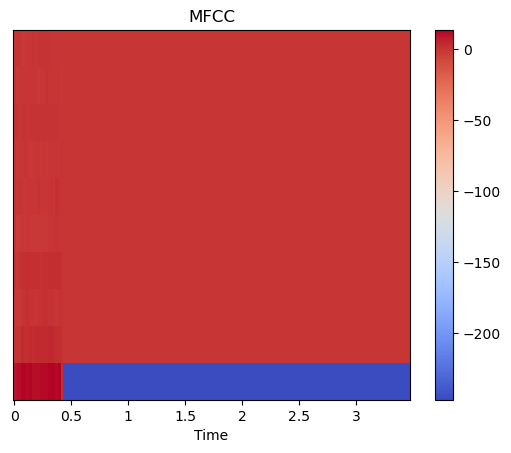

In [30]:
sanity_check_data_prefix = ["../", "Train"]

wav_file = os.path.join(*sanity_check_data_prefix,"2.wav")

np.set_printoptions(threshold=sys.maxsize)

sample_rate, audio = wav.read(wav_file)
if DEBUG:
    print(','.join(str(e) for e in audio.tolist()[:4095]))

audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
audio = librosa.util.fix_length(audio, 16000*3)
features = generate_features(True, audio, SAMPLING_RATE, 
                  WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                  NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

features = features['features']
X = np.expand_dims(features, axis = 0)

results = model(X, training=False)
print(np.argmax(results[0]), np.argmax(results[1][0][0]), np.argmax(results[1][0][1]))
print(f"""
Prediction
Intent:{ids2intents[np.argmax(results[0])]} 
Slot1: {ids2slots[np.argmax(results[1][0][0])]}  Slot2: {ids2slots[np.argmax(results[1][0][1])]}\n
""")
print(ids2intents[np.argmax(results[0])])
IPython.display.Audio(wav_file)